# Demo 03: Filter pings

## Introduction

This Jupyter Notebook contains an introduction to filtering pings by e.g. available features

## Here you will learn

- 

## Short version

At the end of the notebook you will find the important parts of this notebook, compiled into a single cell


## ---

### First: Import the necessary modules

In [1]:
%matplotlib widget
import os
from tqdm.auto import tqdm

import numpy as np

from matplotlib import pyplot as plt
from themachinethatgoesping.echosounders import index_functions
from themachinethatgoesping.echosounders import kongsbergall
import themachinethatgoesping as Ping


In [2]:
# define a list of folder(s) to search for raw data files
folders = []
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")

folders = ["../unittest_data/"]

# find all .all/.wcd files and cache file positions
files = index_functions.find_files(folders, [".all","wcd"])

files = ['../unittest_data/kongsberg/turbeams/9142459809945665151.all',
 '../unittest_data/kongsberg/turbeams/9142459809945665151.wcd']

folders = ["../unittest_data/"]

cache_files = index_functions.get_cache_file_paths(files)

# open all files and index
fm = kongsbergall.KongsbergAllFileHandler(files,cache_files)    

Found 16 files
indexing files ⢀ 98% :00s<00m:00s] [Found: 158 datagrams in 2 files (5MB)]                                       
Initializing datagramdata interface ⠈ 0% :00s<00m:00s]           
Initializing ping interface ⠐ 0% :00s<00m:00s] [Done]                                              


In [3]:
from collections import OrderedDict

class fake_tqdm(object):
    def __init__(self, w_prg):
        self.w_prg = w_prg
        
    def __call__(self, list_like):
        self.list_like = list_like
        self.list_iter = iter(list_like)
        self.index = 0
        self.total = len(list_like)
        self.w_prg.max = self.total
        self.w_prg.value = 0
        return self
        
    def __iter__(self):
        return self
    
    def __next__(self):
        self.index += 1
        self.w_prg.value = self.index
        return next(self.list_iter)
    
    def __len__(self):
        return self.total
    
    def update(self):
        self.index += 1
        next(self.list_iter)
        self.w_prg.value = self.index
        
    def close(self):
        pass

## Filter pings
Pings must contain watercolumn amplitudes to view watercolumn data


In [4]:
print(fm.get_pings()[0])

KongsbergAllPing
################
-
Ping infos 
-------------                                                                                                                                
- Channel id:             TRX-2031                                                                                                                         
- Time info:              18/03/2023 17:37:53.10                                                                                                          
                          [1679161073.100000]
- Features:               .get_timestamp, .get_datetime, .get_channel_id, .get_sensor_configuration, .get_sensor_data_latlon, .get_geolocation             
- Feature groups:         .bottom, .watercolumn                                                                                                            
- Features(.bottom):      .bottom : .get_two_way_travel_times, .get_xyz, .get_tx_signal_parameters, .get_number_of_tx_sectors, .get_beam_cros

"feature" object callable with method "get_[name_of_feature]"

"geolocation" is a feature of ping: ping.get_geolocation()

ping
* geolocation

ping.bottom features
* tx_signal_parameters
* number_of_tx_sectors
* two_way_travel_times
* xyz

ping.watercolumn features
* tx_signal_parameters
* number_of_tx_sectors
* bottom_range_sample
* amplitudes
* av

In [5]:

#ping.bottom.number_of_tx_sectors
#ping.bottom.get_xyz()
#ping.watercolumn.get_bottom_range_sample()
#ping.watercolumn.get_amplitudes()
#ping.watercolumn.get_av()

#txSignalPar = ping.bottom.get_tx_signal_parameters()
#txSignalPar[0].print()
#txSignalPar[0].effective_pulse_duration


ping = fm.get_pings()[0]
ping.print()



KongsbergAllPing
################
-
Ping infos 
-------------                                                                                                                                
- Channel id:             TRX-2031                                                                                                                         
- Time info:              18/03/2023 17:37:53.10                                                                                                          
                          [1679161073.100000]
- Features:               .get_timestamp, .get_datetime, .get_channel_id, .get_sensor_configuration, .get_sensor_data_latlon, .get_geolocation             
- Feature groups:         .bottom, .watercolumn                                                                                                            
- Features(.bottom):      .bottom : .get_two_way_travel_times, .get_xyz, .get_tx_signal_parameters, .get_number_of_tx_sectors, .get_beam_cros

In [6]:
#version one write loop yourself
filtered_pings = []
for ping in tqdm(fm.get_pings()):
    if ping.has_watercolumn():
        if ping.watercolumn.has_feature('av'):
            filtered_pings.append(ping)
print(f'{len(filtered_pings)}/{len(fm.get_pings())}')

  0%|          | 0/12 [00:00<?, ?it/s]

12/12


In [7]:
#version2 use built in function
from themachinethatgoesping.pingprocessing import filter_pings
filtered_pings = filter_pings.by_features(fm.get_pings(),['watercolumn.av'],progress=True)
print(f'{len(filtered_pings)}/{len(fm.get_pings())}')
print(filtered_pings[0])

12/12
KongsbergAllPing
################
-
Ping infos 
-------------                                                                                                                                
- Channel id:             TRX-2031                                                                                                                         
- Time info:              18/03/2023 17:37:53.10                                                                                                          
                          [1679161073.100000]
- Features:               .get_timestamp, .get_datetime, .get_channel_id, .get_sensor_configuration, .get_sensor_data_latlon, .get_geolocation             
- Feature groups:         .bottom, .watercolumn                                                                                                            
- Features(.bottom):      .bottom : .get_two_way_travel_times, .get_xyz, .get_tx_signal_parameters, .get_number_of_tx_sectors, .get_bea

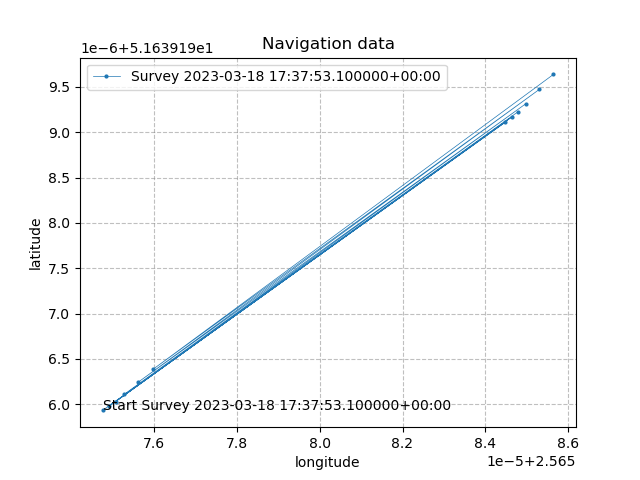

In [8]:
# navigation overview (short version)
from themachinethatgoesping.pingprocessing import overview, split_pings
fig,ax = overview.nav_plot.create_figure('Navigation data', aspect='auto')

# split pings if time difference between pings > 15 minutes
ping_containers = split_pings.by_time_difference(filtered_pings, 15*60)

for key, pings in ping_containers.items():
    stats = overview.get_ping_overview(pings)
    start_time = pings[0].get_datetime()
    stats.plot_navigation(ax, label=f'Survey {start_time}')

ax.legend()

In [9]:
for ping in tqdm(pings[:20000]):
    if ping.has_watercolumn():
        w = ping.file_data.read_merged_watercolumndatagram()
print(w)

  0%|          | 0/12 [00:00<?, ?it/s]

WatercolumnDatagram
###################
- bytes:               62790    
- stx:                 0x02     
- datagram_identifier: 0x6b     [WatercolumnDatagram]
- model_number:        EM2040   
- date:                20230318 [YYYYMMDD]
- time_since_midnight: 63474152 [ms]

 date/time 
-----------   
- timestamp: 1679161074.15 [s]
- date:      18/03/2023    [MM/DD/YYYY]
- time:      17:37:54.152  [HH:MM:SS]

 datagram content 
------------------    
- ping_counter:                29608      
- system_serial_number:        2004       
- number_of_datagrams:         7          
- datagram_number:             1          
- number_of_transmit_sectors:  1          
- total_no_of_receive_beams:   256        
- number_of_beams_in_datagram: 256        
- sound_speed:                 14816      [0.1 m/s]
- sampling_frequency:          2941176    [0.01 Hz]
- tx_time_heave:               -1         [cm]
- tvg_function_applied:        30         
- tvg_offset_in_db:            40         
- scannin

In [10]:
for ping in tqdm(pings[:20000]):
    if ping.has_watercolumn():
        a = ping.watercolumn.get_amplitudes()
print(a)

  0%|          | 0/12 [00:00<?, ?it/s]

[[-128. -128. -128. ...  -19.   -7.  -26.]
 [-128. -128. -128. ...   nan   nan   nan]
 [-128. -128. -128. ...   nan   nan   nan]
 ...
 [-128. -128. -128. ...   nan   nan   nan]
 [-128. -128. -128. ...   nan   nan   nan]
 [-128. -128. -128. ...   nan   nan   nan]]


In [11]:
for ping in tqdm(pings[:20000]):
    if ping.has_watercolumn():
        av = ping.watercolumn.get_av()
print(av)

  0%|          | 0/12 [00:00<?, ?it/s]

[[-85.97043  -90.74164  -92.96013  ... -69.02841  -63.029938 -72.53146 ]
 [-85.97043  -90.74164  -92.96013  ...        nan        nan        nan]
 [-85.97043  -90.74164  -92.96013  ...        nan        nan        nan]
 ...
 [-85.97043  -90.74164  -92.96013  ...        nan        nan        nan]
 [-85.97043  -90.74164  -92.96013  ...        nan        nan        nan]
 [-85.97043  -90.74164  -92.96013  ...        nan        nan        nan]]


In [12]:
filtered_pings

[KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing,
 KongsbergAllPing]

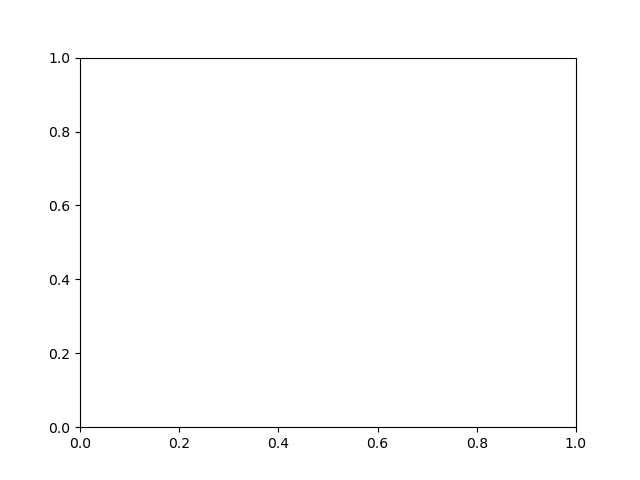

In [13]:
plt.close("WCI")
fig_wci = plt.figure("WCI")
ax_wci = fig_wci.subplots()

In [ ]:
from ipywidgets import *
from time import time
import themachinethatgoesping.pingprocessing.watercolumn.image as mi
import themachinethatgoesping.pingprocessing.watercolumn.helper.make_image_helper as mi_hlp

#filtered_pings, transducers = group_dual_pings(fm.get_pings.get_sorted_by_time())

fig_wci.set_tight_layout(True)

last_split_plot = 100

output = Output()

pss = Ping.echosounders.pingtools.PingSampleSelector()
#pss.select_beam_range_by_angles(-60,-30)


#@widgets.interact
#@debounce(0.1)
@output.capture()
def update(w):  
    try:
        if w_protect_stack.value:
            if w['owner'] != w_wci_stack:
                if float(w_text_execut2ion_time.value) > 0.5:
                    w_wci_stack.value = w_wci_stack.value * 0.5 / float(w_text_execution_time.value)
        if w_wci_stack.value > 1:
            w_wci.step = int(w_wci_stack.value/2)
    except Exception as e:
        pass
    
    w_text_num_total.value = str(int(w_text_num_total.value) +1)
    w_text_num_active.value = str(int(w_text_num_active.value) +1)
    
    t = time()
    global a, last_split_plot, ax_wci, fig_wci, ping1, ping2,wci
    a = w
    #print(w)
    wci_index = w_wci.value
    wci_stack = w_wci_stack.value
    wci_stack_step = w_wci_stack_step.value
    cmin = w_cmin.value
    cmax = w_cmax.value
    aspect = w_aspect.value
    hsize = w_hsize.value
    heads = w_heads.value
    interpolation = w_interpolation.value
    maxz = w_z.value
    from_bottom = w_from_bottom.value
    threshold_white = w_threshold.value
    linear_mean = w_linear_stack.value
     
    ping = filtered_pings[wci_index]
    
    if wci_stack > 1:
        max_index = wci_index+wci_stack
        if max_index > len(filtered_pings):
            max_index = len(filtered_pings)
        pings = []
        for p in filtered_pings[wci_index:max_index:wci_stack_step]:
            pings.append(p)
                
        #pings = pings[::2]
    

    try:
        if wci_stack > 1:
            wci,extent = mi.make_wci_stack(
                pings,
                hsize,
                progress_bar=progress_bar,
                linear_mean=linear_mean,
                from_bottom_xyz=from_bottom,
                mp_cores=w_cores.value)
        else:
            if heads == 'split_dual_rect':
                wci = ping.watercolumn.get_amplitudes()
                extent = [0, ping.watercolumn.get_number_of_beams(),0, ping.watercolumn.get_number_of_samples_per_beam()[0]]
            else:        
                wci,extent = mi.make_wci(
                    ping,
                    hsize,
                    from_bottom_xyz=from_bottom,
                    ping_sample_selector = pss,
                    mp_cores=w_cores.value)
        
                    
        ax_wci.clear()
            
        mapable = ax_wci.imshow(wci.transpose(),aspect=aspect, extent = extent, cmap='YlGnBu_r',vmin=cmin, vmax=cmax,interpolation=interpolation)
        
        if not heads == 'split_dual_rect':
            if not maxz == -1:
                ax_wci.set_ylim(maxz,0)
                               
        w_text_num_active.value = str(int(w_text_num_active.value) -1)
        w_text_execution_time.value = str(round(time()-t,3))
            
        
    except Exception as e:
        #print(e)
        #pass
        raise (e)


w_z = FloatSlider(min=-1, max=50, step=1, value = -1)
w_cmin = FloatSlider(min=-150, max=150, step=5, value = -90)
w_cmax = FloatSlider(min=-150, max=150, step=5, value = 50)
w_wci = IntSlider(min=0, max=len(filtered_pings)-1, step=1, value =0)
w_hsize = IntSlider(min=1, max=2048, step=1, value = 1024)

w_from_bottom = Checkbox(description="from bottom", value=False)
w_linear_stack = Checkbox(description="linear stack", value=True)
w_protect_stack = Checkbox(description="protect stacking time", value=False)
w_threshold = Checkbox(description="threshhold white", value=False)
w_av = Checkbox(description="compute AV", value=True)

w_aspect = Dropdown(options=['auto', 'equal'], value='equal')
w_heads = Dropdown(options=['blend_dual', 'blend_dual_inverse', 'split_dual', 'split_dual_rect'], value='blend_dual')
w_interpolation = Dropdown(options=['antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'], value='nearest')
w_wci_stack = IntText(
    value=1,
    description='stack:',
    disabled=False
)
w_wci_stack_step = IntText(
    value=1,
    description='stack step:',
    disabled=False
)
w_cores = IntText(
    value=1,
    description='cores:',
    disabled=False
)

w_text_num_total = Text(
    value='0',
    placeholder='0',
    description='Total executions:',
    disabled=False   
)
w_text_num_active = Text(
    value='0',
    placeholder='0',
    description='Active executions:',
    disabled=False   
)
w_text_execution_time = Text(
    value='0',
    placeholder='0',
    description='Time of last execution:',
    disabled=False   
)
w_progress = IntProgress(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Stacking:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
progress_bar = fake_tqdm(w_progress)

box_text = HBox([w_text_num_total,w_text_num_active,w_text_execution_time])
box_options = HBox([w_aspect,w_heads,w_interpolation,w_wci_stack,w_wci_stack_step, w_cores])
box_check = HBox([w_from_bottom,w_linear_stack,w_protect_stack, w_threshold, w_av])

w_z.observe(update, names=['value'])
w_cmin.observe(update, names=['value'])
w_cmax.observe(update, names=['value'])
w_wci.observe(update, names=['value'])
w_cores.observe(update, names=['value'])
w_wci_stack.observe(update, names=['value'])
w_wci_stack_step.observe(update, names=['value'])
w_hsize.observe(update, names=['value'])
w_aspect.observe(update, names=['value'])
w_from_bottom.observe(update, names=['value'])
w_threshold.observe(update, names=['value'])
w_av.observe(update, names=['value'])
w_linear_stack.observe(update, names=['value'])
w_heads.observe(update, names=['value'])
w_interpolation.observe(update, names=['value'])


update(0)
display(fig_wci.canvas,output,w_progress, box_text, box_options, box_check, w_z, w_cmin,w_cmax,w_wci,w_hsize)

In [ ]:
grouped_pings = Ping.pingprocessing.group_pings.dual_head(filtered_pings)

In [ ]:
from ipywidgets import *
from time import time
import themachinethatgoesping.pingprocessing.watercolumn.image as mi
import themachinethatgoesping.pingprocessing.watercolumn.helper.make_image_helper as mi_hlp

#filtered_pings, transducers = group_dual_pings(fm.get_pings.get_sorted_by_time())

fig_wci.set_tight_layout(True)

last_split_plot = 100

output = Output()

pss = Ping.echosounders.pingtools.PingSampleSelector()
#pss.select_beam_range_by_angles(-60,-30)


#@widgets.interact
#@debounce(0.1)
@output.capture()
def update(w):  
    try:
        if w_protect_stack.value:
            if w['owner'] != w_wci_stack:
                if float(w_text_execut2ion_time.value) > 0.5:
                    w_wci_stack.value = w_wci_stack.value * 0.5 / float(w_text_execution_time.value)
        if w_wci_stack.value > 1:
            w_wci.step = int(w_wci_stack.value/2)
    except Exception as e:
        pass
    
    w_text_num_total.value = str(int(w_text_num_total.value) +1)
    w_text_num_active.value = str(int(w_text_num_active.value) +1)
    
    t = time()
    global a, last_split_plot, ax_wci, fig_wci, ping1, ping2,wci
    a = w
    #print(w)
    wci_index = w_wci.value
    wci_stack = w_wci_stack.value
    wci_stack_step = w_wci_stack_step.value
    cmin = w_cmin.value
    cmax = w_cmax.value
    aspect = w_aspect.value
    hsize = w_hsize.value
    heads = w_heads.value
    interpolation = w_interpolation.value
    maxz = w_z.value
    from_bottom = w_from_bottom.value
    threshold_white = w_threshold.value
    linear_mean = w_linear_stack.value
     
    ping = grouped_pings[wci_index]
    
    if wci_stack > 1:
        max_index = wci_index+wci_stack
        if max_index > len(grouped_pings):
            max_index = len(grouped_pings)
        pings = []
        for p in grouped_pings[wci_index:max_index:wci_stack_step]:
            pings.append(p)
                
        #pings = pings[::2]
    

    try:
        if wci_stack > 1:
            wci,extent = mi.make_wci_stack(
                pings,
                hsize,
                progress_bar=progress_bar,
                linear_mean=linear_mean,
                from_bottom_xyz=from_bottom,
                mp_cores=w_cores.value)
        else:
            if heads == 'split_dual_rect':
                wci = ping.watercolumn.get_amplitudes()
                extent = [0, ping.watercolumn.get_number_of_beams(),0, ping.watercolumn.get_number_of_samples_per_beam()[0]]
            else:        
                wci,extent = mi.make_wci_dual_head(
                    ping,
                    hsize,
                    from_bottom_xyz=from_bottom,
                    ping_sample_selector = pss,
                    mp_cores=w_cores.value)
        
                    
        ax_wci.clear()
            
        mapable = ax_wci.imshow(wci.transpose(),aspect=aspect, extent = extent, cmap='YlGnBu_r',vmin=cmin, vmax=cmax,interpolation=interpolation)
        
        if not heads == 'split_dual_rect':
            if not maxz == -1:
                ax_wci.set_ylim(maxz,0)
                               
        w_text_num_active.value = str(int(w_text_num_active.value) -1)
        w_text_execution_time.value = str(round(time()-t,3))
            
        
    except Exception as e:
        print(e)
        pass
        #raise (e)


w_z = FloatSlider(min=-1, max=50, step=1, value = -1)
w_cmin = FloatSlider(min=-150, max=150, step=5, value = -90)
w_cmax = FloatSlider(min=-150, max=150, step=5, value = 50)
w_wci = IntSlider(min=0, max=len(grouped_pings)-1, step=1, value =0)
w_hsize = IntSlider(min=1, max=2048, step=1, value = 1024)

w_from_bottom = Checkbox(description="from bottom", value=False)
w_linear_stack = Checkbox(description="linear stack", value=True)
w_protect_stack = Checkbox(description="protect stacking time", value=False)
w_threshold = Checkbox(description="threshhold white", value=False)
w_av = Checkbox(description="compute AV", value=True)

w_aspect = Dropdown(options=['auto', 'equal'], value='equal')
w_heads = Dropdown(options=['blend_dual', 'blend_dual_inverse', 'split_dual', 'split_dual_rect'], value='blend_dual')
w_interpolation = Dropdown(options=['antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'], value='nearest')
w_wci_stack = IntText(
    value=1,
    description='stack:',
    disabled=False
)
w_wci_stack_step = IntText(
    value=1,
    description='stack step:',
    disabled=False
)
w_cores = IntText(
    value=1,
    description='cores:',
    disabled=False
)

w_text_num_total = Text(
    value='0',
    placeholder='0',
    description='Total executions:',
    disabled=False   
)
w_text_num_active = Text(
    value='0',
    placeholder='0',
    description='Active executions:',
    disabled=False   
)
w_text_execution_time = Text(
    value='0',
    placeholder='0',
    description='Time of last execution:',
    disabled=False   
)
w_progress = IntProgress(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Stacking:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
progress_bar = fake_tqdm(w_progress)

box_text = HBox([w_text_num_total,w_text_num_active,w_text_execution_time])
box_options = HBox([w_aspect,w_heads,w_interpolation,w_wci_stack,w_wci_stack_step, w_cores])
box_check = HBox([w_from_bottom,w_linear_stack,w_protect_stack, w_threshold, w_av])

w_z.observe(update, names=['value'])
w_cmin.observe(update, names=['value'])
w_cmax.observe(update, names=['value'])
w_wci.observe(update, names=['value'])
w_cores.observe(update, names=['value'])
w_wci_stack.observe(update, names=['value'])
w_wci_stack_step.observe(update, names=['value'])
w_hsize.observe(update, names=['value'])
w_aspect.observe(update, names=['value'])
w_from_bottom.observe(update, names=['value'])
w_threshold.observe(update, names=['value'])
w_av.observe(update, names=['value'])
w_linear_stack.observe(update, names=['value'])
w_heads.observe(update, names=['value'])
w_interpolation.observe(update, names=['value'])


update(0)
display(fig_wci.canvas,output,w_progress, box_text, box_options, box_check, w_z, w_cmin,w_cmax,w_wci,w_hsize)

In [ ]:
np.arange(3,12+0.5,0.5)